In [3]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from wordcloud import WordCloud


sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (18,8)

In [ ]:
from helpers.analytics import TimeConverter, TimeDelta, TableCreator, GroupBarPlot, CatPlotter, columnsDict



In [25]:
import pyodbc
import pandas as pd
import datetime
import random
import seaborn as sns

def TestConnection():
    with conn:
        try:
            cursor = conn.cursor()
            result = cursor.execute("SELECT * FROM encounter;")
        except pyodbc.ProgrammingError as e:
            print('DB access failed: {}'.format(e))
        else:
            print('Success')


def TableCreator(conn):

    tables = "[procedure] encounter condition observation medicationrequest".split()

    query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES"
    names = pd.read_sql(query, conn)
    # print(names)

    data_dict = {}
    for table in tables:  # can't do from names.TABLE_name because of [procedure]
        # print(table)
        query = "SELECT * FROM {};".format(table)
        print(table)
        data_dict[table] = pd.read_sql(query, conn)

    return data_dict


def TableExplorer(data_dict):
    for table in data_dict.keys():
        # print("{} has shape {}".format(table,data_dict[table].shape))
        if table != "encounter":
            print("{} has {} patients, {} encounters and {} unique ids".format(table,
                                                                               data_dict[table].patient_id.nunique(),
                                                                               data_dict[table].encounter_id.nunique(),
                                                                               data_dict[table].id.nunique()))
        else:
            print("{} has {} patients and {} unique ids".format(table, data_dict[table].patient_id.nunique(),
                                                                data_dict[table].id.nunique()))


def TimeConverter(timecol, fmt="%Y%m%dT%H:%M:%S+00:00"):
    return pd.to_datetime(timecol, format=fmt)


def TimeDelta(start, end, factor):
    if factor == 'Y':
        denominator = pd.to_timedelta(1, unit='days')*365
    elif factor =='M':
        denominator = pd.to_timedelta(1, unit='days')*30
    else:
        denominator = pd.to_timedelta(1, unit=factor)

    return (end - start) / denominator


def GroupBarPlot(table, x, y, index, val):
    # lambda else not callable
    r = lambda: random.randint(0, 255)

    groupDf = table.loc[table[index] == val, [x, y]].groupby(x, as_index=False).mean()

    fig = sns.catplot(x=x, y=y, kind='bar', color='#{:02x}{:02x}{:02x}'.format(r(), r(), r()),
                      data=groupDf)
    plt.xticks(rotation=90)
    (fig.set_axis_labels("Year", val),
     fig.fig.set_figwidth(15),
     fig.fig.set_figheight(8))


def CatPlotter(x, y, val, table):
    r = lambda: random.randint(0, 255)

    fig = sns.catplot(x=x, y=y, color='#{:02x}{:02x}{:02x}'.format(r(), r(), r()),
                      kind="violin", orient='h', data=table.loc[table[y] == val])
    (fig.set_axis_labels("Hours", ""),
     fig.fig.set_figwidth(12),
     fig.fig.set_figheight(10))


def DataframeCleaner(table):
    table = table.apply(lambda x: x.astype(str))  # not the fastest
    table = table.groupby(table.columns, axis=1).agg(lambda x: ' | '.join(x.values))

    table.replace(' | ', '', inplace=True)
    table.replace(' |  | ', '', inplace=True)

    table.sort_index(axis=1, inplace=True)

    return table




columnsDict = {'medicationrequest':{'target':'medicationCodeableConcept', 'time':'authoredOn'},
            '[procedure]':{'target':'code', 'time':'performedPeriod_start'},
            'condition':{'target':'code', 'time':'onsetDateTime'},
            'encounter':{'target':'type', 'time':'period_start'},
            'observation':{'target':'code', 'time':'effectiveDateTime'},
           }

In [19]:
dataDict = {}

for table in ['condition', 'observation', '[procedure]', 'medicationrequest','encounter']:
    dataDict[table] = pd.read_table('/Users/bonaventurapacileo/Documents/HP_interview/data/'+table+'-2.csv', sep=',')



In [ ]:
conn = pyodbc.connect(
    'Driver={ODBC Driver 17 for SQL Server};'
    'Server=35.204.21.80,1433;'
    'Database=master;'
    'uid=sa;pwd=Password123')



dataDict = TableCreator(conn)

### Data preparation

In [ ]:
# Data Preparation
for table in dataDict:
    
    dataDict[table][columnsDict[table]['time']] = TimeConverter(dataDict[table][columnsDict[table]['time']])





# In[11]:

dataDict['condition']['clinicalStatusDuration'] = TimeDelta(start=dataDict['condition']['onsetDateTime'],
                                                           end=datetime.datetime.now(),factor='Y')




# In[12]:

dataDict['encounter']['period_end'] = TimeConverter(dataDict['encounter']['period_end'])
dataDict['[procedure]']['performedPeriod_end'] = TimeConverter(dataDict['[procedure]']['performedPeriod_end'])


# In[13]:

dataDict['encounter']['encounterDuration'] = TimeDelta(end=dataDict['encounter']['period_end'],
                                              start=dataDict['encounter']['period_start'],factor='H')



# In[14]:

dataDict['observation']['value']=dataDict['observation']['value'].astype('float')



# In[15]:

dataDict['observation']['year']=dataDict['observation']['effectiveDateTime'].dt.year



# In[16]:


dataDict['[procedure]']['year']=dataDict['[procedure]']['performedPeriod_end'].dt.year
dataDict['[procedure]']['month']=dataDict['[procedure]']['performedPeriod_end'].dt.month




    

### Condition table

(<seaborn.axisgrid.FacetGrid at 0x1a211b3630>, None, None)

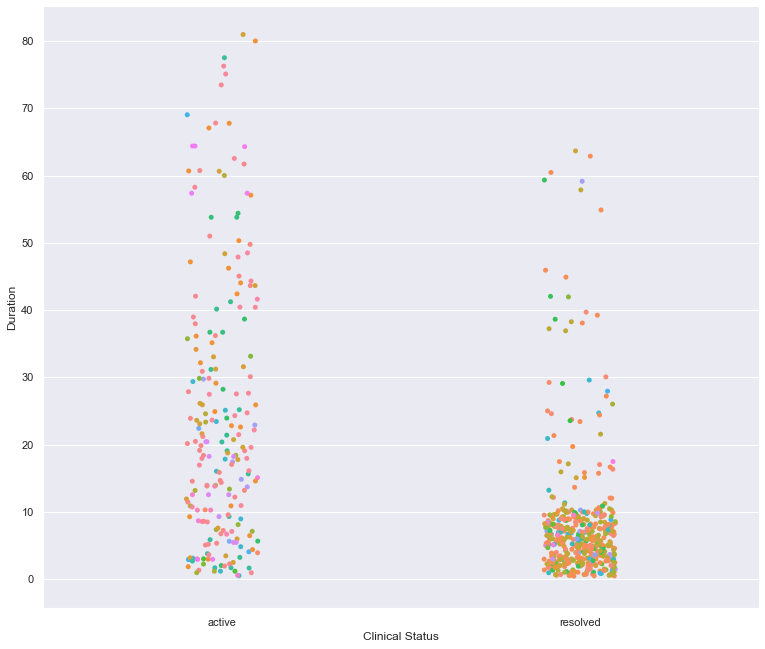

In [28]:
fig=sns.catplot(x="clinicalStatus", y="clinicalStatusDuration", hue="code", data=dataDict['condition'], legend=False)
(fig.set_axis_labels("Clinical Status", "Duration"),fig.fig.set_figwidth(12),
    fig.fig.set_figheight(10))




### Encounter tables

[None, None, None, None, None]

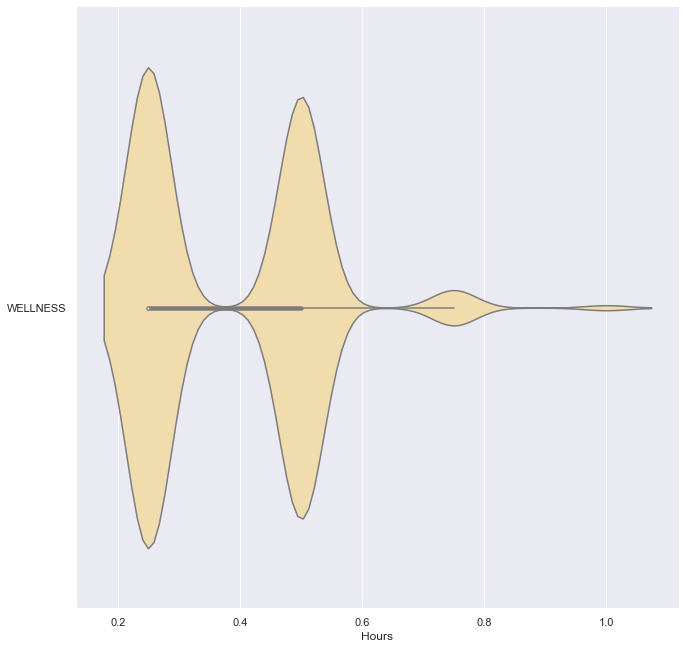

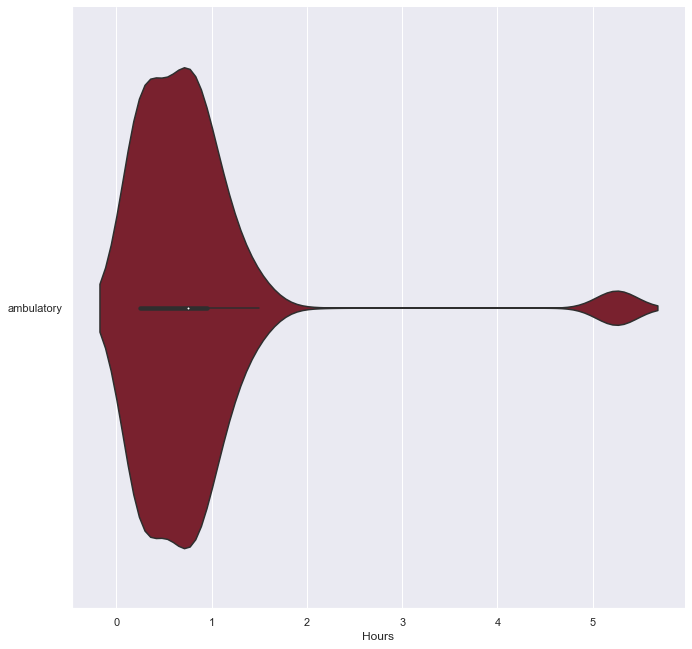

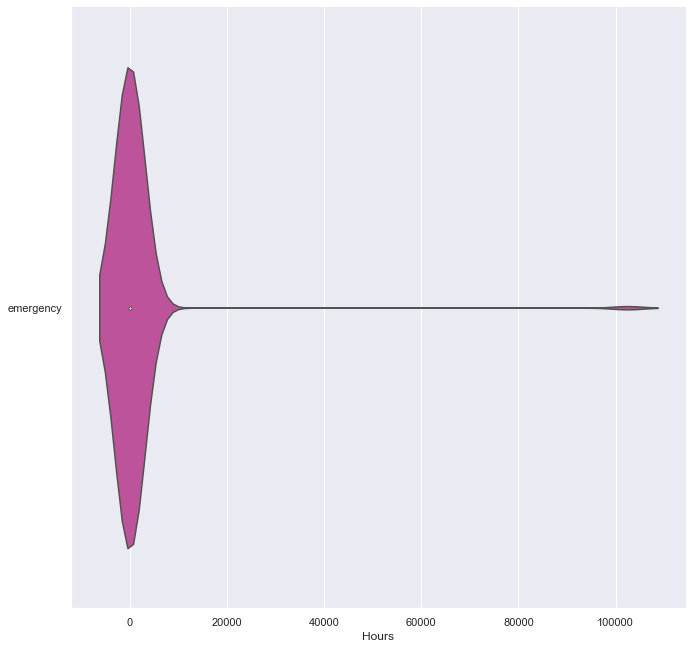

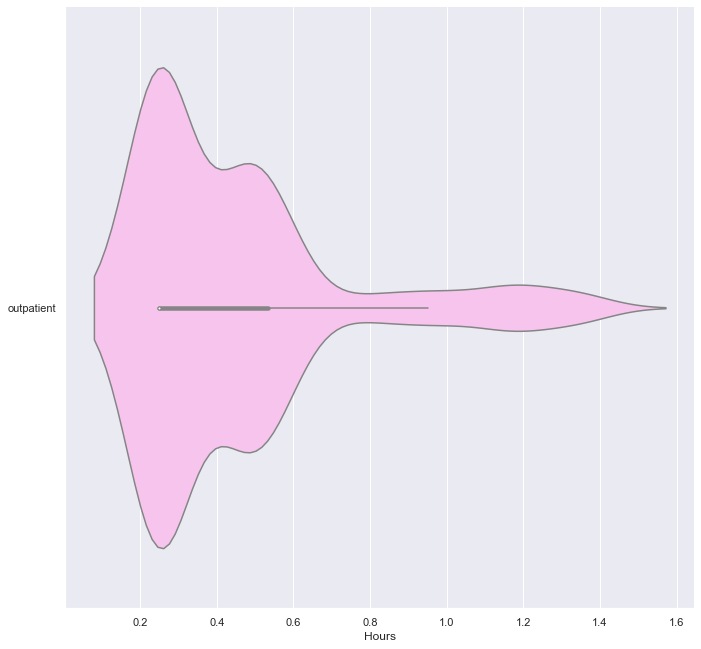

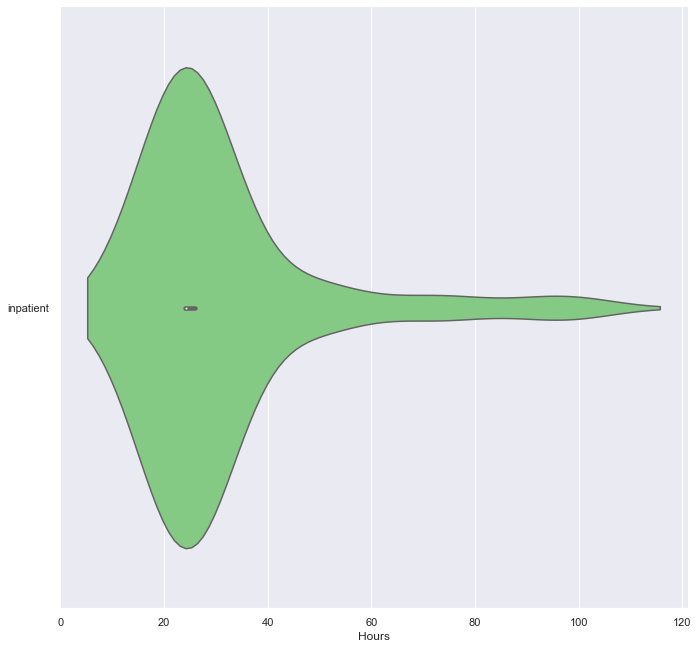

In [29]:
[CatPlotter(y='class', x="encounterDuration", val=val, table=dataDict['encounter']) for val in dataDict['encounter']['class'].unique()]



### Observation tables

In [30]:
print(dataDict['observation']['code'].value_counts()[:5])



Body Height                                 1058
Body Weight                                 1058
Blood Pressure                              1058
Body Mass Index                              877
Hemoglobin A1c/Hemoglobin.total in Blood     566
Name: code, dtype: int64


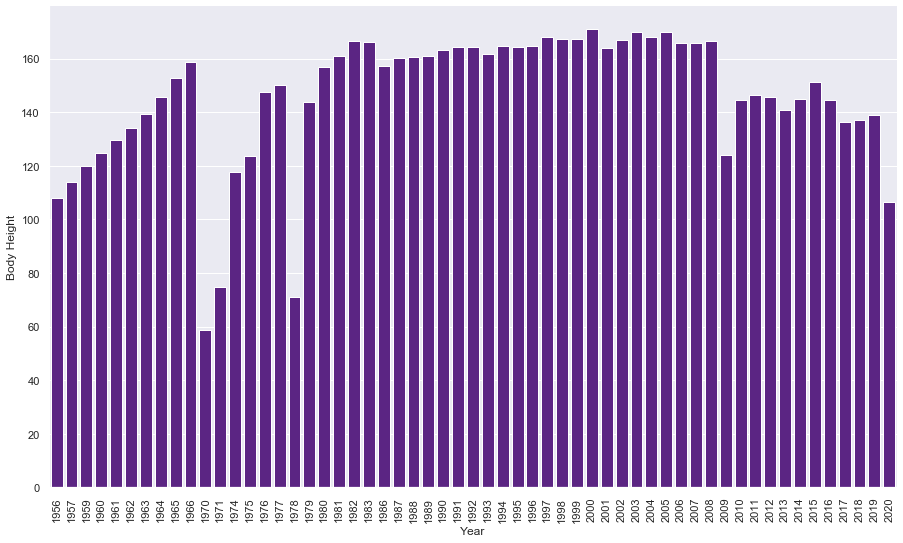

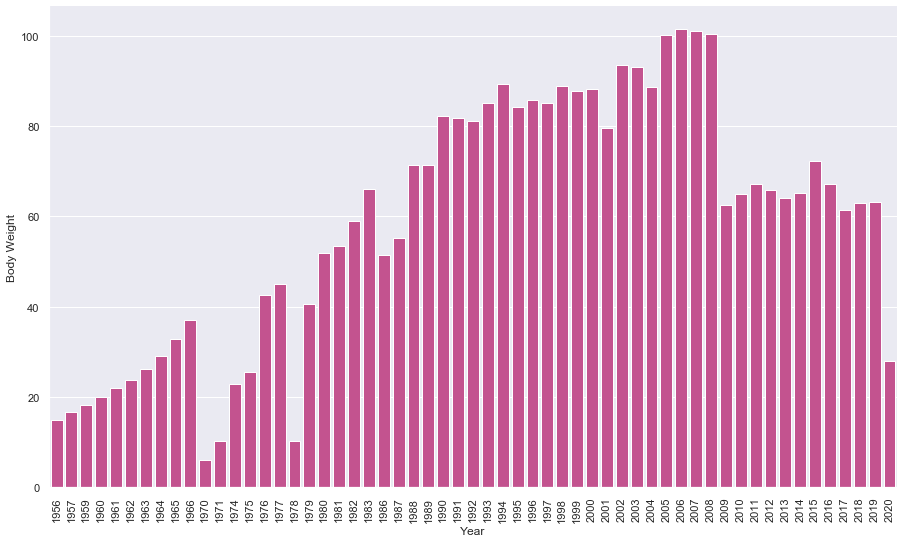

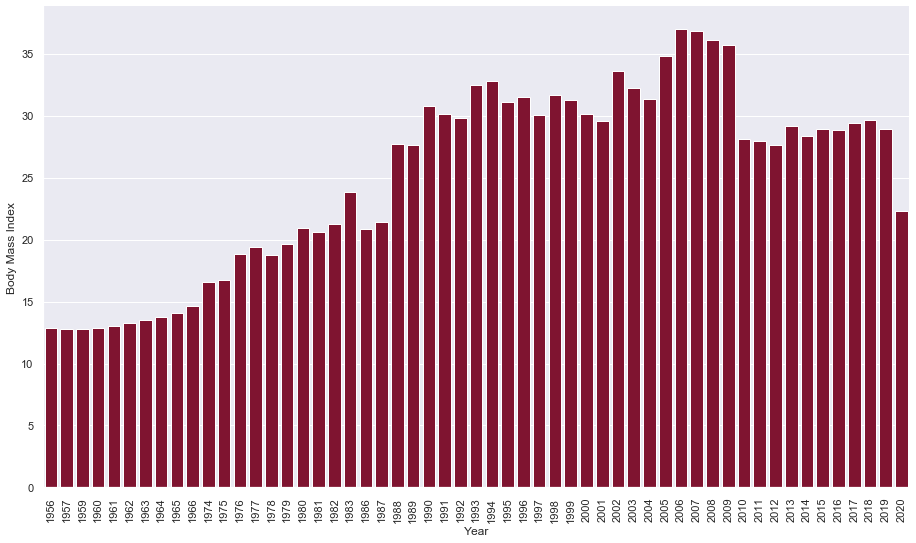

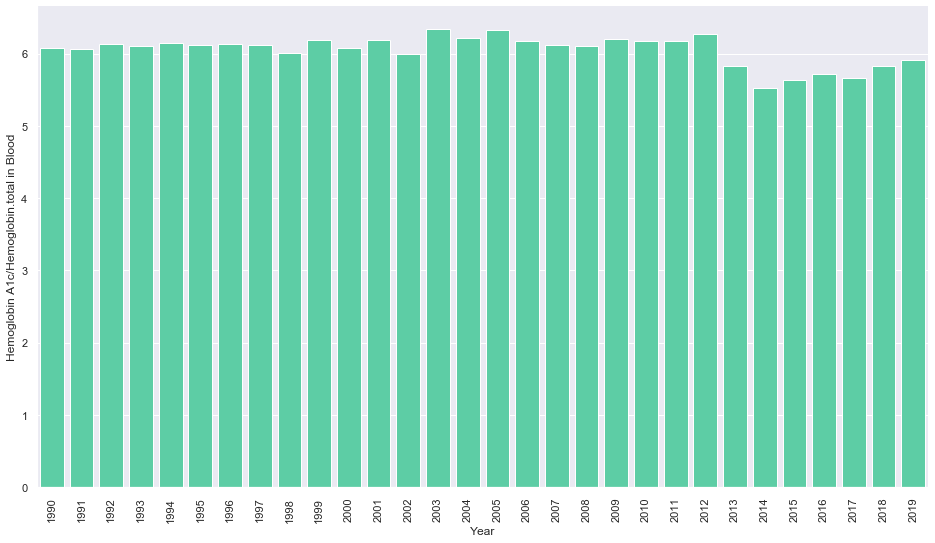

In [31]:
for val in ['Body Height','Body Weight','Body Mass Index', 'Hemoglobin A1c/Hemoglobin.total in Blood']:

    GroupBarPlot(dataDict['observation'],x='year',y='value',index='code',val=val)



### Medication request table

In [32]:
wordcloud = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 10).generate(' '.join(dataDict['medicationrequest']['medicationCodeableConcept'])) 



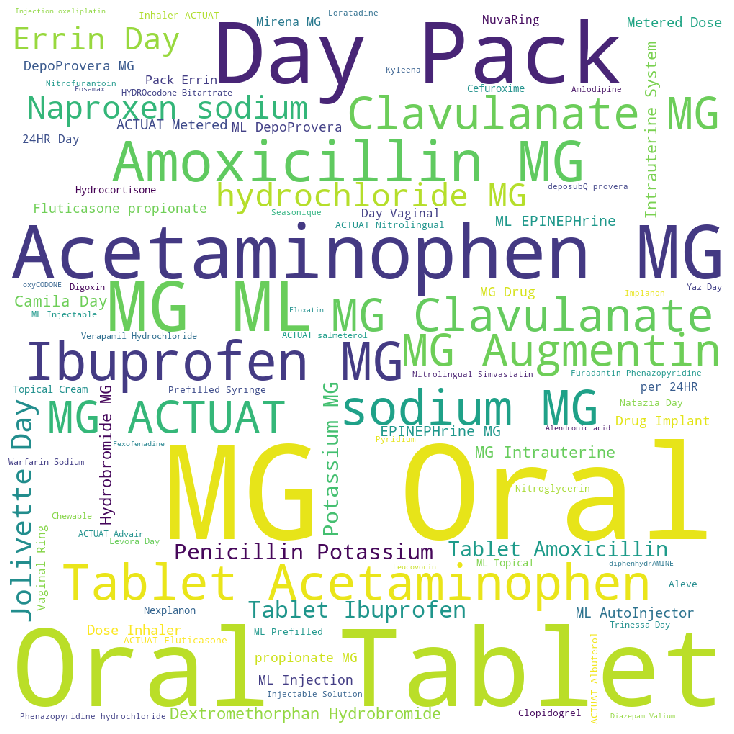

In [33]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

### Procedure table

In [34]:
groupedProcedureDf = dataDict['[procedure]'][['reasonReference_display','year','month']].groupby(['year','month'], as_index=False).count()
groupedProcedureDf = groupedProcedureDf.pivot("month", "year", "reasonReference_display")



(Text(0.5, 48.5, 'Year'),
 Text(138.5, 0.5, 'Month'),
 Text(0.5, 1, 'Frequency of procedures'))

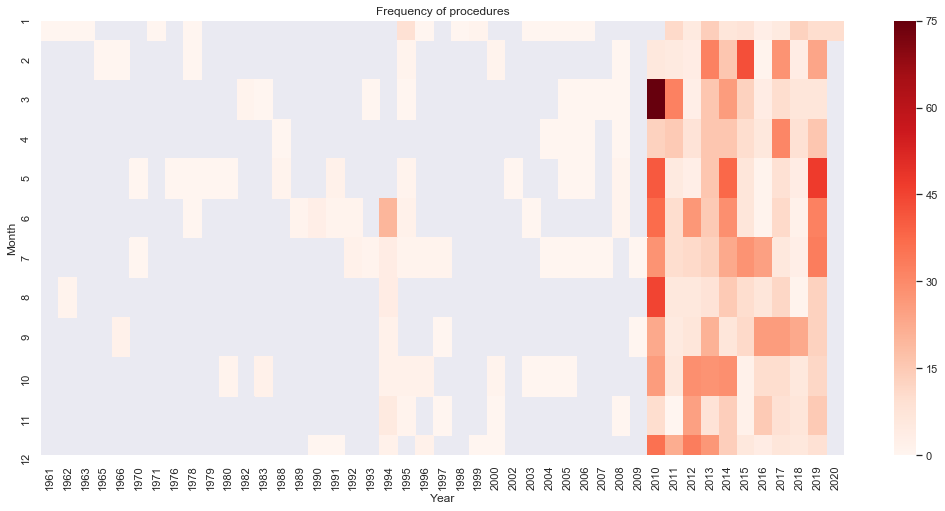

In [36]:

ax = sns.heatmap(groupedProcedureDf,cmap='Reds')
(ax.set_xlabel("Year"),ax.set_ylabel("Month"),
 ax.set_title('Frequency of procedures'))  


